In [101]:
# === SETUP: Run this first! ===
import os
import sys

# Change to project root and add to Python path
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)  # Goes up one level from 'notebooks/'
os.chdir(project_root)
sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"tsnn module path: {os.path.join(project_root, 'tsnn')}")

Project root: /Users/gremy/Code
tsnn module path: /Users/gremy/Code/tsnn


In [102]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
#sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math
from typing import Optional
from tsnn.tstorch import transformers



plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
from dataclasses import dataclass
from torch import nn
device = 'mps'

In [104]:
# This notebook will be used to compare different models.

# Basic comparison of models

## Time series data

In [124]:
@dataclass
class Config:
    T: int = 3000
    n_ts: int = 10
    n_f: int = 10
    #T: int = 2000
    #n_ts: int = 5
    #n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.25
    split_shift: float = 0.25
    split_seasonal: float = 0.
    split_cs: float = 0.25
    split_cs_shift: float = 0.25
    low_corr: float = 0.3
    high_corr: float = 0.5

# @dataclass
# class Config:
#     T: int = 3000
#     n_ts: int = 20
#     n_f: int = 10
#     pct_zero_corr: float = 0.5
#     split_conditional: float = 1.0
#     split_shift: float = 0.
#     split_seasonal: float = 0.
#     split_cs: float = 0.
#     split_cs_shift: float = 0.
#     low_corr: float = 0.1
#     high_corr: float = 0.2


In [125]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [126]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 9.67 ms, sys: 6.04 ms, total: 15.7 ms
Wall time: 16.2 ms


In [127]:
z.get_dataloader(n_rolling=10)

## NN and Transformer models

In [128]:
# First a basic fully connect MLP:

class GlobalMLP(nn.Module):
    def __init__(
        self,
        n_ts,          # N
        n_f,           # F
        n_rolling,     # T
        hidden_dim=512,
        num_layers=4,
        dropout=0.1,
    ):
        super().__init__()
        
        input_dim = n_rolling * n_ts * n_f
        
        layers = []
        dim = input_dim
        for i in range(num_layers):
            layers.append(nn.Linear(dim, hidden_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            dim = hidden_dim
        
        # Final projection to N targets
        layers.append(nn.Linear(hidden_dim, n_ts))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: (B, T, N, F)
        """
        B = x.shape[0]
        x = x.reshape(B, -1)          # (B, T*N*F)
        out = self.network(x)         # (B, N)
        return out

In [129]:
# Next a per series than global MLP

class PerSeriesThenGlobalMLP(nn.Module):
    def __init__(
        self,
        n_ts,          # N
        n_f,           # F
        n_rolling,     # T
        d_model=256,   # hidden size after per-series processing
        hidden_global=512,
        num_layers_local=3,
        num_layers_global=3,
        dropout=0.1,
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.d_model = d_model
        
        # --------------------------------------------------------------
        # 1. Local MLP: applied independently to each series
        #    Input per series: T × F  →  collapses to d_model
        # --------------------------------------------------------------
        local_layers = []
        dim = n_rolling * n_f
        for i in range(num_layers_local):
            local_layers.extend([
                nn.Linear(dim, d_model),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.LayerNorm(d_model)
            ])
            dim = d_model
        # Final local projection
        local_layers.append(nn.Linear(dim, d_model))
        self.local_mlp = nn.Sequential(*local_layers)
        
        # --------------------------------------------------------------
        # 2. Global MLP: mixes information across the N series
        #    Input: N × d_model  →  N
        # --------------------------------------------------------------
        global_layers = []
        dim = n_ts * d_model
        for i in range(num_layers_global):
            global_layers.extend([
                nn.Linear(dim, hidden_global),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.LayerNorm(hidden_global)
            ])
            dim = hidden_global
        global_layers.append(nn.Linear(hidden_global, n_ts))
        self.global_mlp = nn.Sequential(*global_layers)

    def forward(self, x):
        """
        x: (B, T, N, F)
        """
        B, T, N, F = x.shape
        
        # Reshape so each series becomes a separate "sample"
        x = x.permute(0, 2, 1, 3).reshape(B * N, T * F)   # (B*N, T*F)
        
        # Local processing: each series gets its own embedding
        local_emb = self.local_mlp(x)                     # (B*N, d_model)
        
        # Reshape back to have the series dimension explicit
        x_global = local_emb.view(B, N * self.d_model)    # (B, N*d_model)
        
        # Global mixing across series
        out = self.global_mlp(x_global)                   # (B, N)
        
        return out

In [130]:
# Basic transformer model with TS attention.

class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [131]:

# Transformer model with both TS then CS attention.

class DualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,          # number of time series (N)
        n_f,           # number of input features per timestamp
        n_rolling,     # lookback window length (T)
        d_model=128,
        nhead_time=8,      # heads for temporal attention (stage 1)
        nhead_series=8,    # heads for cross-series attention (stage 2)
        num_layers_time=1,
        num_layers_series=1,
        dim_feedforward=512,
        dropout=0.8,
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        # ------------------------------------------------------------------
        # 1. Input projection: (n_f) → d_model  (shared across all series & timesteps)
        # ------------------------------------------------------------------
        self.input_proj = nn.Linear(n_f, d_model)

        # Positional encoding for the temporal dimension (stage 1)
        self.pos_emb_time = nn.Parameter(torch.randn(1, n_rolling, d_model))
        # self.pos_emb_time = torch.arange(1, n_rolling)

        # ------------------------------------------------------------------
        # Stage 1: Temporal Transformer (attention over time, independent per series)
        # ------------------------------------------------------------------
        temporal_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_time,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.temporal_transformer = nn.TransformerEncoder(
            temporal_layer, num_layers=num_layers_time
        )

        # Causal mask for temporal attention (autoregressive within the window)
        self.register_buffer(
            "causal_mask_time",
            torch.triu(torch.ones(n_rolling, n_rolling), diagonal=1).bool()
        )

        # ------------------------------------------------------------------
        # Stage 2: Cross-Series Transformer (attention over the N series)
        # ------------------------------------------------------------------
        series_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_series,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.series_transformer = nn.TransformerEncoder(
            series_layer, num_layers=num_layers_series
        )

        # Optional positional encoding for the series dimension
        # (can be learned or fixed; here learned)
        
        self.pos_emb_series = nn.Parameter(torch.randn(1, n_ts, d_model))
        # self.pos_emb_series = torch.arange(1, n_ts)

        # ------------------------------------------------------------------
        # Final prediction head: d_model → 1 (forecast scalar per series)
        # ------------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x : (B, n_rolling, n_ts, n_f)   float tensor
        Returns: (B, n_ts)               predicted scalar for each series
        """
        B, T, N, F = x.shape  # T = n_rolling, N = n_ts, F = n_f

        # ------------------------------------------------------------------
        # 1. Project features → d_model
        # ------------------------------------------------------------------
        # (B, T, N, F) → (B, T, N, d_model)
        x = self.input_proj(x)

        # ------------------------------------------------------------------
        # 2. Reshape so that batch × series becomes the new "batch"
        #    → (B*N, T, d_model)
        # ------------------------------------------------------------------
        x = x.permute(0, 2, 1, 3).reshape(B * N, T, self.d_model)  # (B*N, T, d_model)

        # Add temporal positional encoding
        x = x + self.pos_emb_time[:, :T, :]

        # ------------------------------------------------------------------
        # 3. Temporal Transformer (causal attention over time)
        # ------------------------------------------------------------------
        x = self.temporal_transformer(x, mask=self.causal_mask_time)  # (B*N, T, d_model)

        # Take the last timestep representation
        x_last = x[:, -1, :]  # (B*N, d_model)

        # ------------------------------------------------------------------
        # 4. Reshape back to have series dimension explicit
        #    → (B, N, d_model)
        # ------------------------------------------------------------------
        x_series = x_last.view(B, N, self.d_model)

        # Add series positional encoding
        x_series = x_series + self.pos_emb_series

        # ------------------------------------------------------------------
        # 5. Cross-Series Transformer (full attention over the N series)
        # ------------------------------------------------------------------
        # No mask needed here → full bidirectional attention across series
        x_series = self.series_transformer(x_series)  # (B, N, d_model)

        # ------------------------------------------------------------------
        # 6. Final prediction
        # ------------------------------------------------------------------
        out = self.output_head(x_series)      # (B, N, 1)
        out = out.squeeze(-1)                 # (B, N) = (B, n_ts)

        return out

In [132]:
# MLP in the TS dimension, then transformer in CS dimension.

class MLPSpatioTransformer(nn.Module):
    """
    Architecture:
    1. Treat each series independently → collapse (T, F) → d_model via shared MLP
    2. Reshape to (B, N, d_model)
    3. Apply Transformer with attention over the N series (cross-series communication)
    4. Predict one scalar per series from the final d_model representations
    """
    def __init__(
        self,
        n_ts,              # N: number of time series
        n_f,               # F: number of input features
        n_rolling,         # T: lookback length
        d_model=256,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.8,
        mlp_layers=3,      # depth of the per-series MLP
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        # --------------------------------------------------------------
        # 1. Per-series MLP: processes each (T, F) window independently
        #    Input size per series: T * F
        # --------------------------------------------------------------
        input_dim = n_rolling * n_f
        mlp = []
        dim = input_dim
        
        for i in range(mlp_layers):
            mlp.extend([
                nn.Linear(dim, d_model),
                nn.GELU(),
                nn.LayerNorm(d_model),
                nn.Dropout(dropout)
            ])
            dim = d_model
            
        # Final projection to exact d_model (in case of residual connections or skip)
        mlp.append(nn.Linear(dim, d_model))
        self.per_series_mlp = nn.Sequential(*mlp)

        # --------------------------------------------------------------
        # 2. Positional encoding for the series dimension (N)
        #    (learned, because series usually don't have natural ordering)
        # --------------------------------------------------------------
        self.pos_embedding = nn.Parameter(torch.randn(1, n_ts, d_model))

        # --------------------------------------------------------------
        # 3. Cross-series Transformer (attention over the N dimension)
        # --------------------------------------------------------------
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # --------------------------------------------------------------
        # 4. Final prediction head: d_model → 1
        # --------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x : (B, T, N, F)
        Returns: (B, N)
        """
        B, T, N, F = x.shape

        # --------------------------------------------------------------
        # 1. Reshape so each series is a separate sample
        #    (B, T, N, F) → (B*N, T*F)
        # --------------------------------------------------------------
        x = x.permute(0, 2, 1, 3).reshape(B * N, T * F)   # (B*N, T*F)

        # --------------------------------------------------------------
        # 2. Per-series MLP encoding
        # --------------------------------------------------------------
        h = self.per_series_mlp(x)                        # (B*N, d_model)

        # --------------------------------------------------------------
        # 3. Reshape back to explicit series dimension
        #    (B*N, d_model) → (B, N, d_model)
        # --------------------------------------------------------------
        h = h.view(B, N, self.d_model)

        # Add learned positional encoding for the series axis
        h = h + self.pos_embedding

        # --------------------------------------------------------------
        # 4. Cross-series Transformer (full bidirectional attention over N)
        # --------------------------------------------------------------
        h = self.transformer(h)                           # (B, N, d_model)

        # --------------------------------------------------------------
        # 5. Final prediction
        # --------------------------------------------------------------
        out = self.output_head(h)                         # (B, N, 1)
        out = out.squeeze(-1)                             # (B, N)

        return out

In [133]:
# Lets add one more model, alternating TS and CS transformers.
class AlternatingDualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        d_model=128,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts

        self.input_proj = nn.Linear(n_f, d_model)

        # ←←← THIS IS THE FIX ←←←
        self.pos_emb_time   = nn.Parameter(torch.randn(1, 1, d_model))   # broadcasts over T
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))   # broadcasts over N

        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList()
        for _ in range(num_layers):
            temp = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout,
                                          activation="gelu", batch_first=True),
                num_layers=1
            )
            series = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout,
                                          activation="gelu", batch_first=True),
                num_layers=1
            )
            self.blocks.append(nn.ModuleDict({
                'temporal': temp,
                'series': series,
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
            }))

        self.register_buffer("causal_mask",
                             torch.triu(torch.ones(n_rolling, n_rolling), diagonal=1).bool())

        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        B, T, N, _ = x.shape

        x = self.input_proj(x)                                  # (B,T,N,d_model)

        # ←←← NOW SAFE ←←←
        x = x + self.pos_emb_time + self.pos_emb_series

        for block in self.blocks:
            # Temporal
            res = x
            x = x.permute(0, 2, 1, 3).reshape(B*N, T, self.d_model)
            x = block['temporal'](x, mask=self.causal_mask)
            x = x.reshape(B, N, T, self.d_model).permute(0, 2, 1, 3)
            x = block['norm1'](res + self.dropout(x))

            # Cross-series
            res = x
            x = x.reshape(B*T, N, self.d_model)
            x = block['series'](x)
            x = x.reshape(B, T, N, self.d_model)
            x = block['norm2'](res + self.dropout(x))

        # Take last timestep
        x = x[:, -1, :, :]                                      # (B, N, d_model)
        return self.output_head(x).squeeze(-1)

In [134]:
class AlternatingDualAttentionTransformer2(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        mask,
        d_model=128,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
        sparsify=None
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts
        self.mask = mask
        self.sparsify = sparsify

        self.input_proj = nn.Linear(n_f, d_model)

        # Broadcasted positional embeddings
        self.pos_emb_time   = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))

        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList()
        for _ in range(num_layers):
            temp = transformers.TransformerEncoder(
                transformers.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout),
                num_layers=1
            )
            # we only use the self_attn module from this one — series attention is custom
            series = transformers.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
            self.blocks.append(nn.ModuleDict({
                'temporal': temp,
                'series': series,
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
            }))

        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def series_attention(self, x, attn_layer):
        """
        x: (B, T, N, d)
        Applies attention independently for each (B, T) window over the N dimension.
        """
        B, T, N, D = x.shape

        x_flat = x.view(B*T, N, D)

        out = attn_layer.self_attn(x_flat, x_flat, x_flat,)

        out = out.view(B, T, N, D)
        return out
    
    def temporal_attention(self, x, attn_encoder):
        """
        x: (B, T, N, D)
        Applies temporal attention independently for each series (N dimension)
        using the stored TransformerEncoder.
        """
        B, T, N, D = x.shape
        x_flat = x.transpose(1, 2).contiguous().view(B*N, T, D)

        out = attn_encoder(x_flat, mask=self.mask, sparsify=self.sparsify)

        out = out.view(B, N, T, D).transpose(1, 2)
        return out

    def forward(self, x):
        B, T, N, _ = x.shape

        x = self.input_proj(x)

        # broadcast positional embeddings
        x = x + self.pos_emb_time + self.pos_emb_series

        for block in self.blocks:
            # temporal
            res = x
            x_t = self.temporal_attention(x, block['temporal'])
            x = block['norm1']((res + self.dropout(x_t)).contiguous())

            # series
            res = x
            x_s = self.series_attention(x, block['series'])
            x = block['norm2']((res + self.dropout(x_s)).contiguous())

        # final timestep → (B, N, d)
        x = x[:, -1, :, :]

        return self.output_head(x).squeeze(-1)

## Running the models

In [135]:
# Let's now run the five models above (or a subset of them) on the generated data.

100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


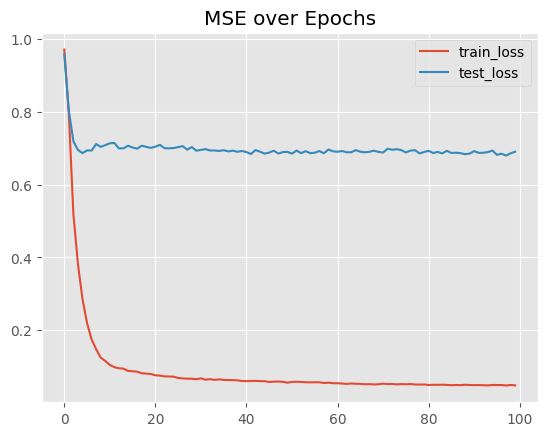

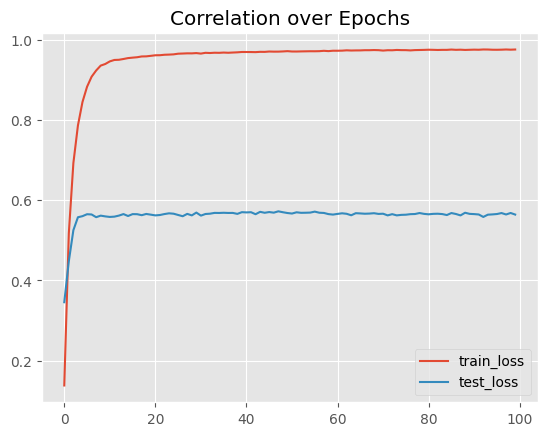

In [136]:
m = GlobalMLP(Config.n_ts, Config.n_f, 10, dropout=0.2).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_nn1 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_nn1.fit(z.train, test=z.test, epochs=100)

100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


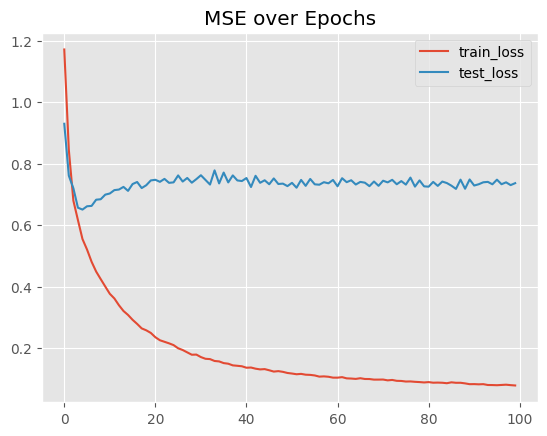

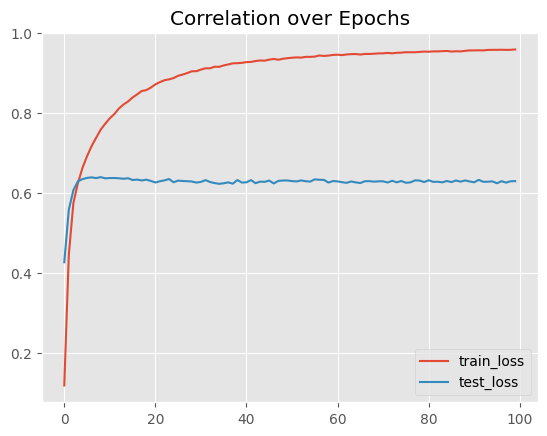

In [137]:
m = PerSeriesThenGlobalMLP(Config.n_ts, Config.n_f, 10, dropout=0.2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_nn2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_nn2.fit(z.train, test=z.test, epochs=100)

100%|██████████| 80/80 [00:35<00:00,  2.26it/s]


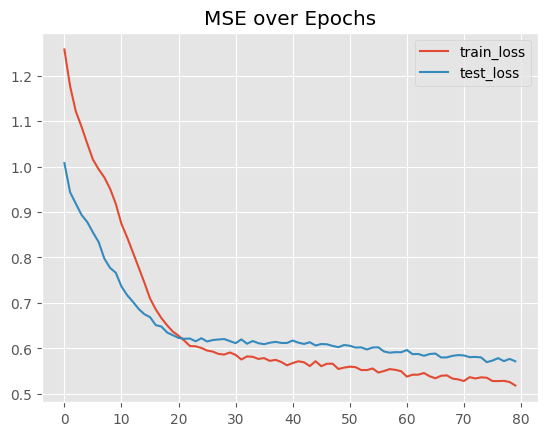

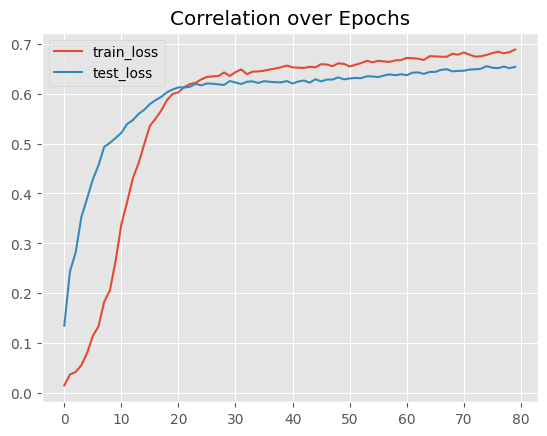

In [138]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch.fit(z.train, test=z.test, epochs=80)

100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


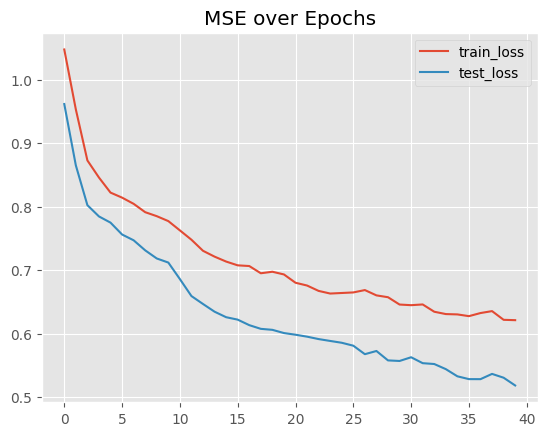

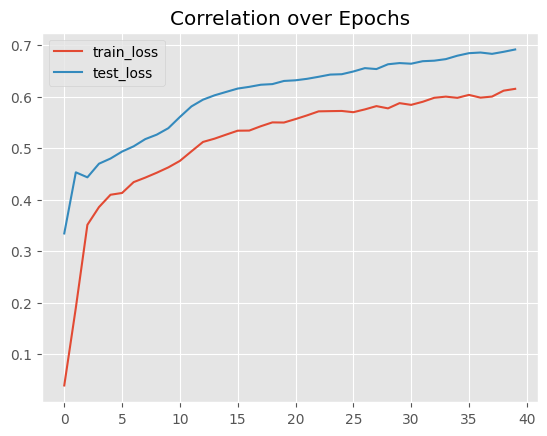

In [139]:
m = DualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=32, dim_feedforward=512, dropout=0.5, num_layers_series=2, num_layers_time=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch2.fit(z.train, test=z.test, epochs=40)

/Users/cyrilgarcia/miniconda3/envs/cyril10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:11<00:00,  5.14it/s]


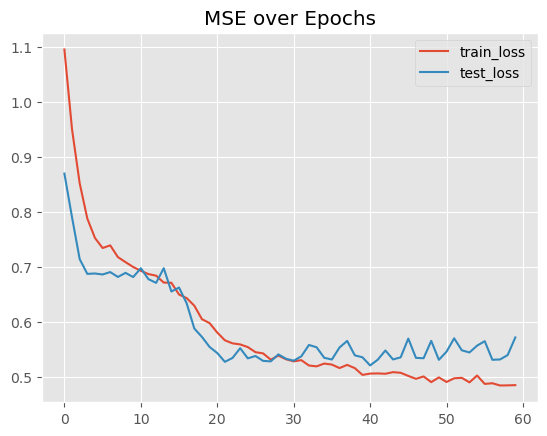

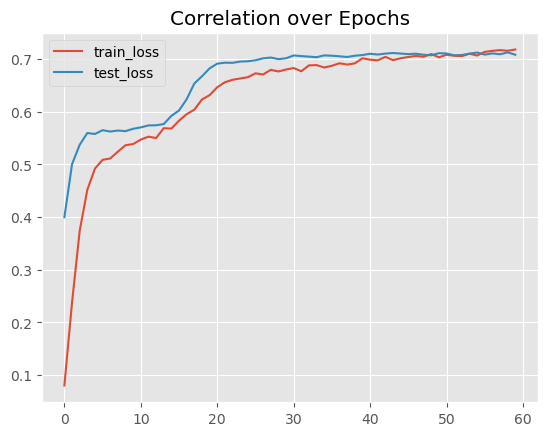

In [27]:
m = MLPSpatioTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2, mlp_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch3 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch3.fit(z.train, test=z.test, epochs=60)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [02:32<00:00,  2.55s/it]


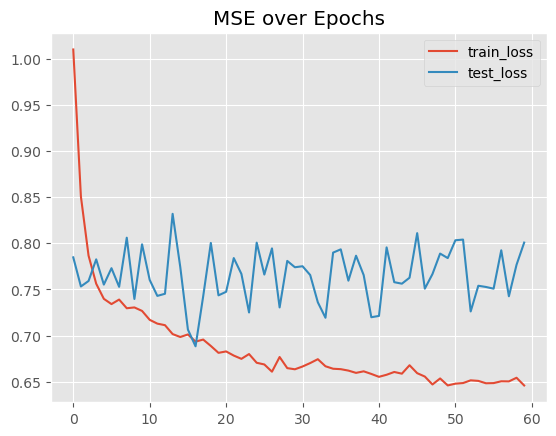

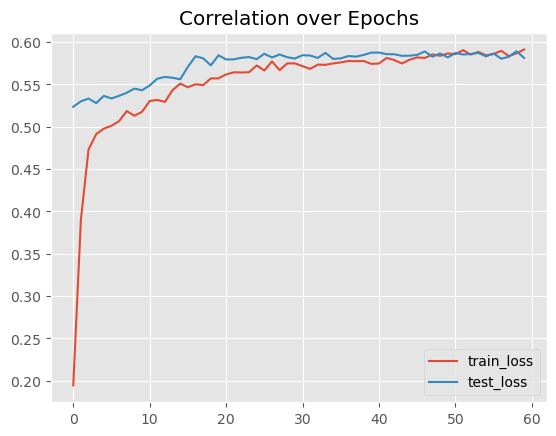

In [30]:
m = AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch4 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch4.fit(z.train, test=z.test, epochs=60)

In [20]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [ ]:
device='mps'
m = AlternatingDualAttentionTransformer2(Config.n_ts, Config.n_f, 10, mask=mask, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)
m = torch.compile(m, backend="eager")

model_torch5 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch5.fit(z.train, test=z.test, epochs=60)

 43%|████████████████████████████████████████████▋                                                          | 26/60 [00:51<01:01,  1.81s/it]

## Comparison

In [37]:
comp = benchmark_comparison.Comparator(models=[model_nn1, model_nn2, model_torch, model_torch2, model_torch3, model_torch4, model_torch5],
                                        model_names=['NN1', 'NN2', 'transformer', 'transformer2', 'transformer3', 'transformer4', 'transformer5'])

# comp = benchmark_comparison.Comparator(models=[model_nn1, model_nn2, model_torch],
#                                         model_names=['NN1', 'NN2', 'transformer'])

In [38]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,NN1,NN2,transformer,transformer2,transformer3,transformer4
optimal,0.678,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.445,0.608,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.333,0.468,0.154,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
shift,0.367,0.522,0.167,0.118,nan,nan,nan,nan,nan,nan,nan,nan,nan
cs,0.375,0.586,0.162,0.129,0.146,nan,nan,nan,nan,nan,nan,nan,nan
cs_shift,0.396,0.626,0.173,0.138,0.153,0.161,nan,nan,nan,nan,nan,nan,nan
NN1,0.992,0.676,0.443,0.332,0.365,0.373,0.396,nan,nan,nan,nan,nan,nan
NN2,0.992,0.660,0.434,0.329,0.356,0.363,0.384,0.984,nan,nan,nan,nan,nan
transformer,0.735,0.763,0.636,0.249,0.331,0.536,0.357,0.731,0.717,nan,nan,nan,nan
transformer2,0.662,0.772,0.697,0.396,0.517,0.321,0.286,0.659,0.646,0.829,nan,nan,nan


In [39]:
comp.correl(z, mode='test')

python(24000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(24010) Malloc

,true,optimal,linear,conditional,shift,cs,cs_shift,NN1,NN2,transformer,transformer2,transformer3,transformer4
optimal,0.679,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.431,0.610,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.330,0.456,0.139,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
shift,0.352,0.504,0.144,0.117,nan,nan,nan,nan,nan,nan,nan,nan,nan
cs,0.374,0.575,0.165,0.107,0.135,nan,nan,nan,nan,nan,nan,nan,nan
cs_shift,0.399,0.620,0.178,0.133,0.124,0.137,nan,nan,nan,nan,nan,nan,nan
NN1,0.575,0.688,0.461,0.186,0.396,0.397,0.430,nan,nan,nan,nan,nan,nan
NN2,0.635,0.753,0.524,0.208,0.418,0.444,0.456,0.755,nan,nan,nan,nan,nan
transformer,0.670,0.741,0.633,0.209,0.307,0.527,0.332,0.764,0.812,nan,nan,nan,nan
transformer2,0.649,0.763,0.696,0.381,0.500,0.310,0.272,0.675,0.749,0.821,nan,nan,nan


# Same as above with just one effect

## cs_shift effect

In [ ]:
# @dataclass
# class Config:
#     T: int = 3000
#     n_ts: int = 50
#     n_f: int = 10
#     pct_zero_corr: float = 0.5
#     split_conditional: float = 0.25
#     split_shift: float = 0.25
#     split_seasonal: float = 0.
#     split_cs: float = 0.25
#     split_cs_shift: float = 0.25
#     low_corr: float = 0.1
#     high_corr: float = 0.2

@dataclass
class Config:
    T: int = 3000
    n_ts: int = 10
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.
    split_shift: float = 0.
    split_seasonal: float = 0.
    split_cs: float = 0.
    split_cs_shift: float = 1.0
    low_corr: float = 0.1
    high_corr: float = 0.2


In [ ]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [ ]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 8.46 ms, sys: 2.15 ms, total: 10.6 ms
Wall time: 9.5 ms


In [ ]:
z.get_dataloader(n_rolling=10)

100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


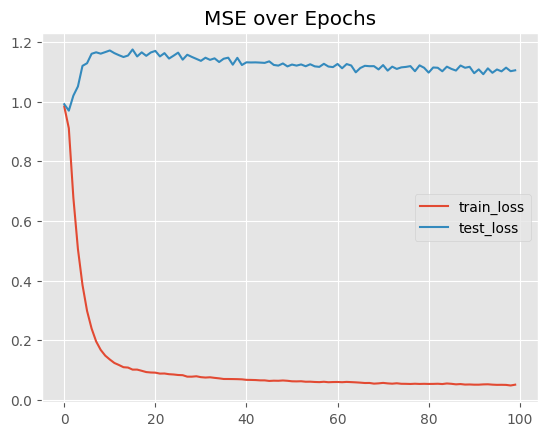

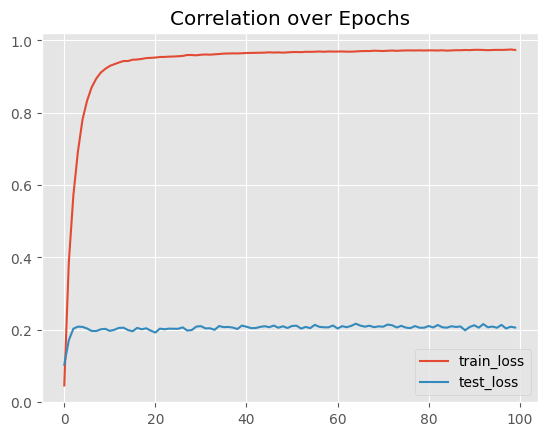

In [ ]:
m = GlobalMLP(Config.n_ts, Config.n_f, 10, dropout=0.2).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_nn1 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_nn1.fit(z.train, test=z.test, epochs=100)

100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


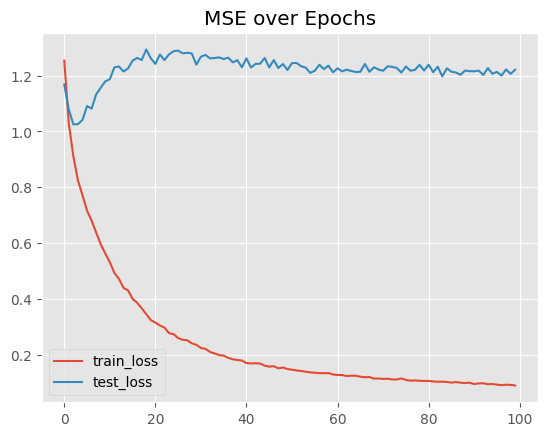

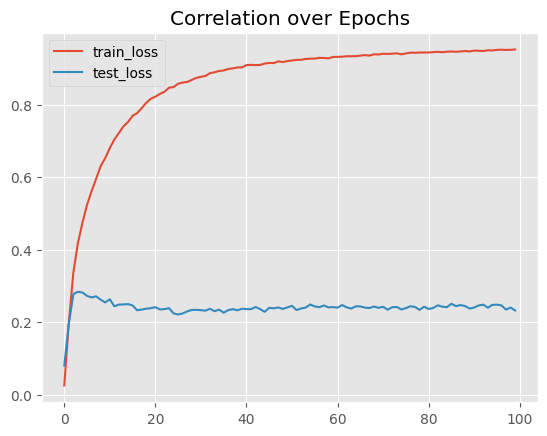

In [ ]:
m = PerSeriesThenGlobalMLP(Config.n_ts, Config.n_f, 10, dropout=0.2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_nn2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_nn2.fit(z.train, test=z.test, epochs=100)

100%|██████████| 80/80 [00:16<00:00,  4.94it/s]


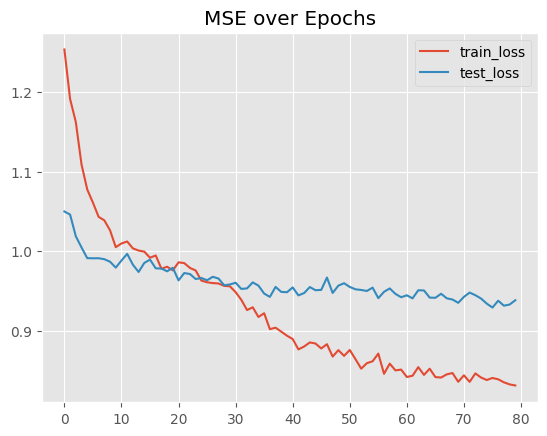

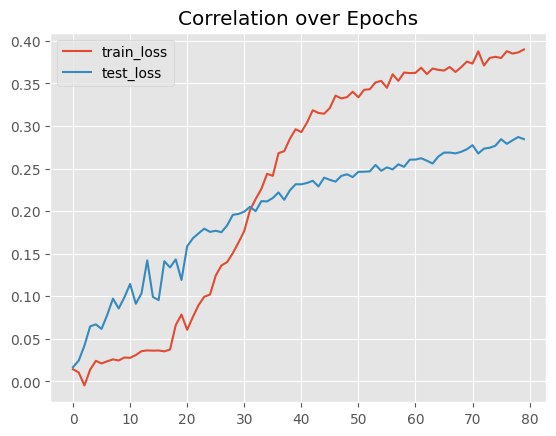

In [ ]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch.fit(z.train, test=z.test, epochs=80)

100%|██████████| 60/60 [01:02<00:00,  1.03s/it]


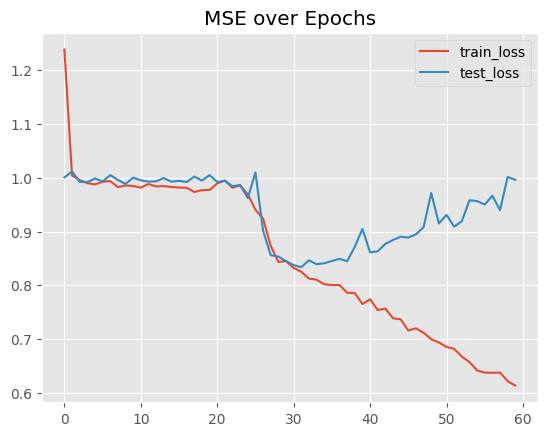

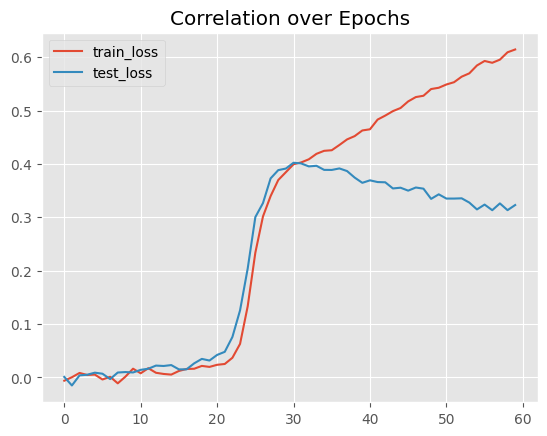

In [ ]:
m = DualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.2, num_layers_series=2, num_layers_time=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch2.fit(z.train, test=z.test, epochs=60)

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
100%|██████████| 60/60 [00:12<00:00,  4.93it/s]


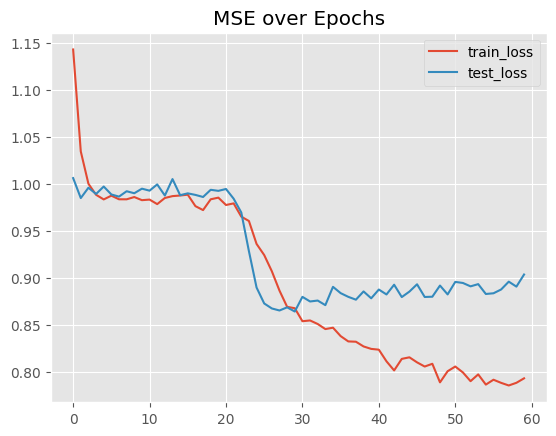

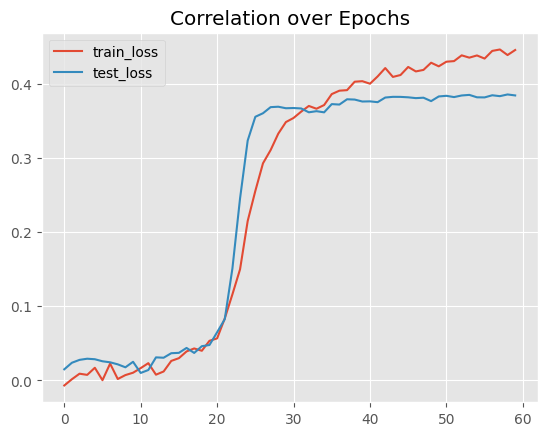

In [ ]:
m = MLPSpatioTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2, mlp_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch3 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch3.fit(z.train, test=z.test, epochs=60)

100%|██████████| 60/60 [01:54<00:00,  1.91s/it]


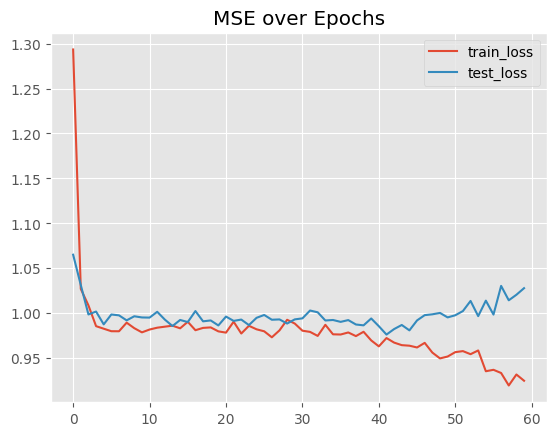

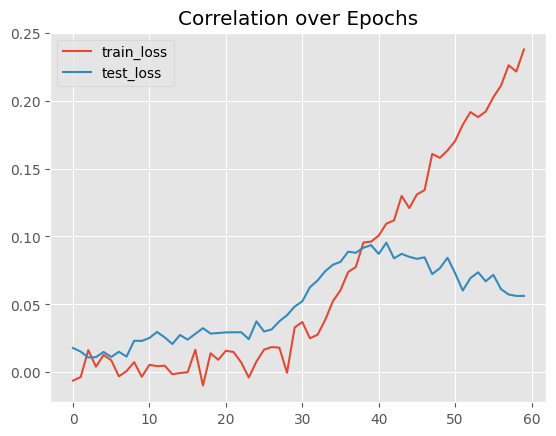

In [ ]:
m = AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.2, num_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch4 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch4.fit(z.train, test=z.test, epochs=60)

In [ ]:
comp = benchmark_comparison.Comparator(models=[model_nn1, model_nn2, model_torch, model_torch2, model_torch3, model_torch4],
                                        model_names=['NN1', 'NN2', 'transformer', 'transformer2', 'transformer3', 'transformer4'])

In [ ]:
comp.correl(z, mode='train')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,cs_shift,NN1,NN2,transformer,transformer2,transformer3
optimal,0.313,nan,nan,nan,nan,nan,nan,nan
cs_shift,0.313,1.000,nan,nan,nan,nan,nan,nan
NN1,0.993,0.313,0.313,nan,nan,nan,nan,nan
NN2,0.991,0.301,0.301,0.984,nan,nan,nan,nan
transformer,0.452,0.311,0.311,0.452,0.440,nan,nan,nan
transformer2,0.729,0.539,0.539,0.726,0.717,0.629,nan,nan
transformer3,0.502,0.693,0.693,0.501,0.487,0.710,0.754,nan
transformer4,0.309,0.114,0.114,0.304,0.303,0.260,0.300,0.255


In [ ]:
comp.correl(z, mode='test')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,cs_shift,NN1,NN2,transformer,transformer2,transformer3
optimal,0.308,nan,nan,nan,nan,nan,nan,nan
cs_shift,0.308,1.000,nan,nan,nan,nan,nan,nan
NN1,0.208,0.369,0.369,nan,nan,nan,nan,nan
NN2,0.237,0.440,0.440,0.508,nan,nan,nan,nan
transformer,0.285,0.268,0.268,0.494,0.483,nan,nan,nan
transformer2,0.318,0.572,0.572,0.414,0.486,0.593,nan,nan
transformer3,0.384,0.691,0.691,0.482,0.588,0.668,0.760,nan
transformer4,0.057,0.048,0.048,0.069,0.094,0.166,0.153,0.150


## conditional effect

In [ ]:
# @dataclass
# class Config:
#     T: int = 3000
#     n_ts: int = 50
#     n_f: int = 10
#     pct_zero_corr: float = 0.5
#     split_conditional: float = 0.25
#     split_shift: float = 0.25
#     split_seasonal: float = 0.
#     split_cs: float = 0.25
#     split_cs_shift: float = 0.25
#     low_corr: float = 0.1
#     high_corr: float = 0.2

@dataclass
class Config:
    T: int = 3000
    n_ts: int = 10
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 1.0
    split_shift: float = 0.
    split_seasonal: float = 0.
    split_cs: float = 0.
    split_cs_shift: float = 0.
    low_corr: float = 0.1
    high_corr: float = 0.2


In [ ]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [ ]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 11.9 ms, sys: 10.6 ms, total: 22.5 ms
Wall time: 28.3 ms


In [ ]:
z.get_dataloader(n_rolling=10)

100%|██████████| 100/100 [00:10<00:00,  9.14it/s]


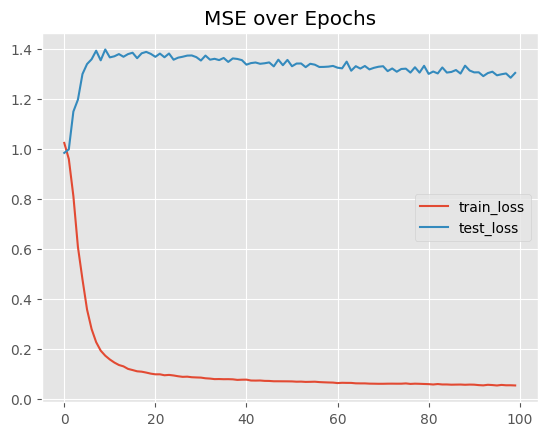

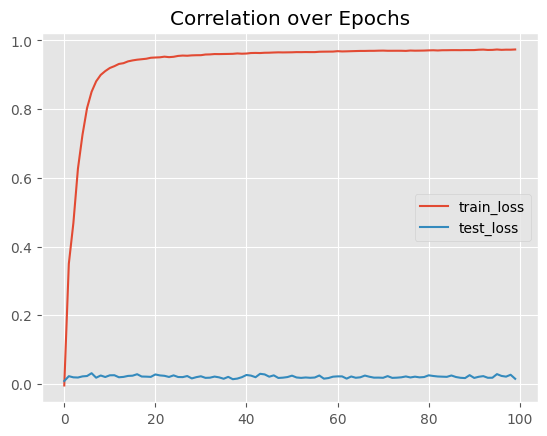

In [ ]:
m = GlobalMLP(Config.n_ts, Config.n_f, 10, dropout=0.2).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_nn1 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_nn1.fit(z.train, test=z.test, epochs=100)

100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


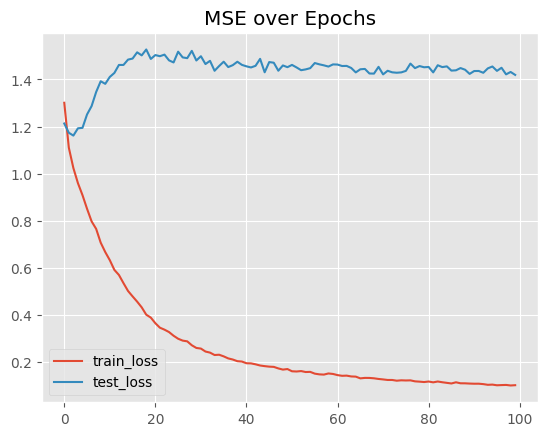

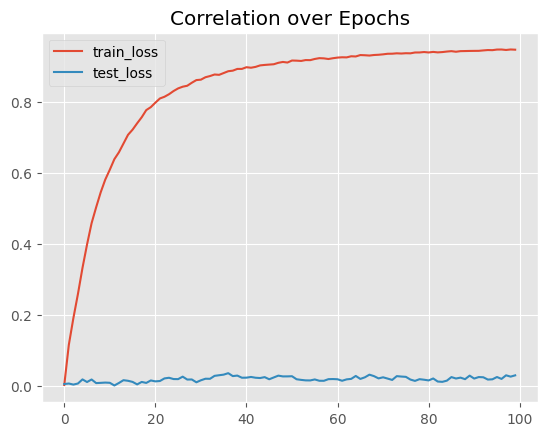

In [ ]:
m = PerSeriesThenGlobalMLP(Config.n_ts, Config.n_f, 10, dropout=0.2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_nn2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_nn2.fit(z.train, test=z.test, epochs=100)

100%|██████████| 80/80 [00:16<00:00,  4.73it/s]


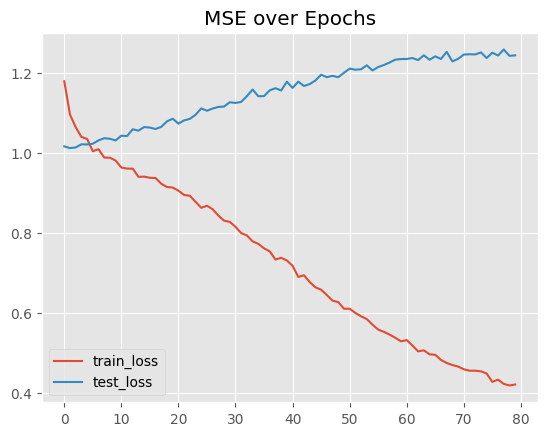

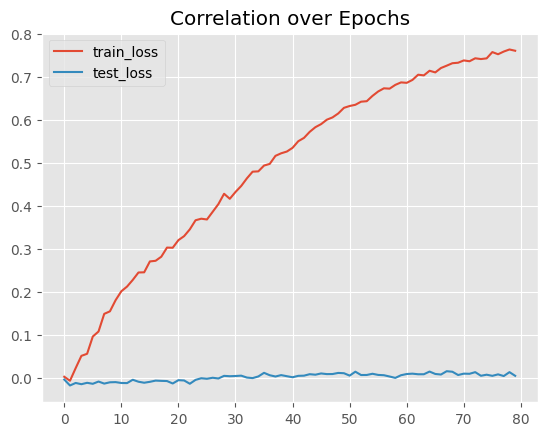

In [ ]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, dropout=0.5).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch.fit(z.train, test=z.test, epochs=80)

100%|██████████| 40/40 [00:42<00:00,  1.07s/it]


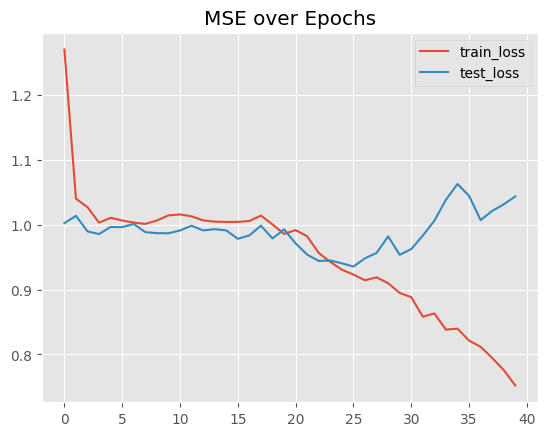

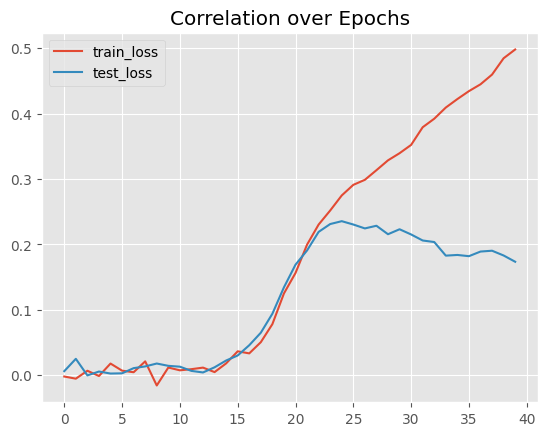

In [ ]:
m = DualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.2, num_layers_series=2, num_layers_time=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch2.fit(z.train, test=z.test, epochs=40)

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
100%|██████████| 60/60 [00:12<00:00,  4.77it/s]


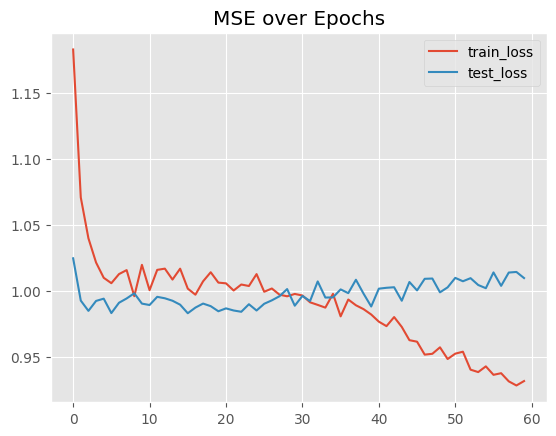

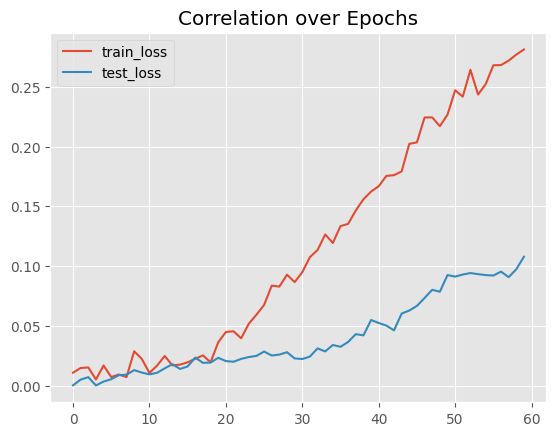

In [ ]:
m = MLPSpatioTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2, mlp_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch3 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch3.fit(z.train, test=z.test, epochs=60)

100%|██████████| 60/60 [01:54<00:00,  1.92s/it]


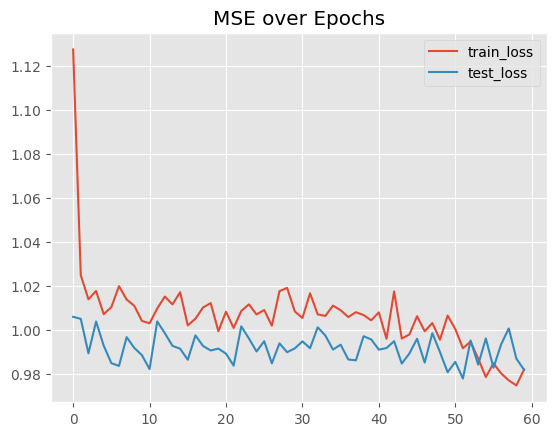

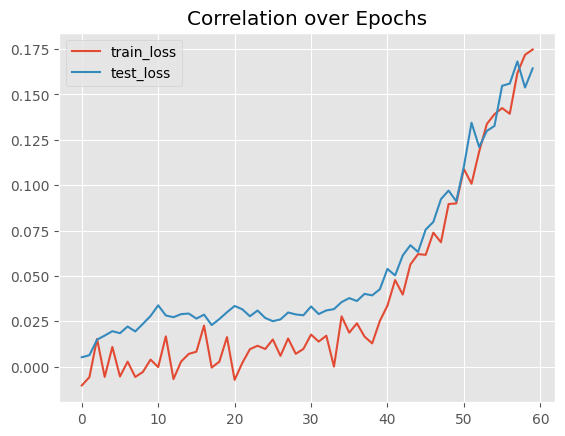

In [ ]:
m = AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch4 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch4.fit(z.train, test=z.test, epochs=60)

In [ ]:
comp = benchmark_comparison.Comparator(models=[model_nn1, model_nn2, model_torch, model_torch2, model_torch3, model_torch4],
                                        model_names=['NN1', 'NN2', 'transformer', 'transformer2', 'transformer3', 'transformer4'])

In [ ]:
comp.correl(z, mode='train')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,conditional,NN1,NN2,transformer,transformer2,transformer3
optimal,0.340,nan,nan,nan,nan,nan,nan,nan
conditional,0.340,1.000,nan,nan,nan,nan,nan,nan
NN1,0.993,0.339,0.339,nan,nan,nan,nan,nan
NN2,0.991,0.337,0.337,0.983,nan,nan,nan,nan
transformer,0.923,0.327,0.327,0.917,0.913,nan,nan,nan
transformer2,0.615,0.581,0.581,0.611,0.608,0.599,nan,nan
transformer3,0.456,0.408,0.408,0.452,0.450,0.441,0.535,nan
transformer4,0.236,0.516,0.516,0.235,0.234,0.235,0.475,0.417


In [ ]:
comp.correl(z, mode='test')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,conditional,NN1,NN2,transformer,transformer2,transformer3
optimal,0.334,nan,nan,nan,nan,nan,nan,nan
conditional,0.334,1.000,nan,nan,nan,nan,nan,nan
NN1,0.019,0.016,0.016,nan,nan,nan,nan,nan
NN2,0.025,0.033,0.033,0.335,nan,nan,nan,nan
transformer,0.007,0.039,0.039,0.330,0.148,nan,nan,nan
transformer2,0.172,0.557,0.557,0.080,0.044,0.136,nan,nan
transformer3,0.104,0.325,0.325,0.106,0.046,0.075,0.421,nan
transformer4,0.165,0.494,0.494,0.024,0.014,0.060,0.482,0.379


# Testing the sparse attention

## Basic setup

In [ ]:
@dataclass
class Config:
    T: int = 3000
    n_ts: int = 10
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.
    split_shift: float = 0.
    split_seasonal: float = 0.
    split_cs: float = 0.
    split_cs_shift: float = 1.0
    low_corr: float = 0.1
    high_corr: float = 0.2


In [ ]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [ ]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 9.65 ms, sys: 2.69 ms, total: 12.3 ms
Wall time: 11.1 ms


In [ ]:
z.get_dataloader(n_rolling=10)

In [ ]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return q_idx >= (kv_idx+100)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [ ]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

,0,1,2,3,4
0,1,0,0,0,0
1,1,1,0,0,0
2,1,1,1,0,0
3,1,1,1,1,0
4,1,1,1,1,1


## Models with sparse attention

In [ ]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModelSparse(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5, attn_l1_coeff=0, sparsify=None):
        super().__init__()
        self.mask = mask
        self.sparsify = sparsify
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask, sparsify=self.sparsify)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [ ]:

# Transformer model with both TS then CS attention.

class DualAttentionTransformerSparse(nn.Module):
    def __init__(
        self,
        n_ts,          # number of time series (N)
        n_f,           # number of input features per timestamp
        n_rolling,     # lookback window length (T)
        mask,
        d_model=128,
        nhead_time=8,      # heads for temporal attention (stage 1)
        nhead_series=8,    # heads for cross-series attention (stage 2)
        num_layers_time=1,
        num_layers_series=1,
        dim_feedforward=512,
        dropout=0.8,
        sparsify=None
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        self.mask = mask
        self.sparsify = sparsify
        # ------------------------------------------------------------------
        # 1. Input projection: (n_f) → d_model  (shared across all series & timesteps)
        # ------------------------------------------------------------------
        self.input_proj = nn.Linear(n_f, d_model)

        # Positional encoding for the temporal dimension (stage 1)
        self.pos_emb_time = nn.Parameter(torch.randn(1, n_rolling, d_model))
        # self.pos_emb_time = torch.arange(1, n_rolling)

        # ------------------------------------------------------------------
        # Stage 1: Temporal Transformer (attention over time, independent per series)
        # ------------------------------------------------------------------
        temporal_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_time,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            # activation="gelu",
        )
        self.temporal_transformer = transformers.TransformerEncoder(
            temporal_layer, num_layers=num_layers_time
        )

        # ------------------------------------------------------------------
        # Stage 2: Cross-Series Transformer (attention over the N series)
        # ------------------------------------------------------------------
        series_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_series,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            # activation="gelu",
        )
        self.series_transformer = transformers.TransformerEncoder(
            series_layer, num_layers=num_layers_series
        )

        # Optional positional encoding for the series dimension
        # (can be learned or fixed; here learned)
        
        self.pos_emb_series = nn.Parameter(torch.randn(1, n_ts, d_model))
        # self.pos_emb_series = torch.arange(1, n_ts)

        # ------------------------------------------------------------------
        # Final prediction head: d_model → 1 (forecast scalar per series)
        # ------------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x : (B, n_rolling, n_ts, n_f)   float tensor
        Returns: (B, n_ts)               predicted scalar for each series
        """
        B, T, N, F = x.shape  # T = n_rolling, N = n_ts, F = n_f

        # ------------------------------------------------------------------
        # 1. Project features → d_model
        # ------------------------------------------------------------------
        # (B, T, N, F) → (B, T, N, d_model)
        x = self.input_proj(x)

        # ------------------------------------------------------------------
        # 2. Reshape so that batch × series becomes the new "batch"
        #    → (B*N, T, d_model)
        # ------------------------------------------------------------------
        x = x.permute(0, 2, 1, 3).reshape(B * N, T, self.d_model)  # (B*N, T, d_model)

        # Add temporal positional encoding
        x = x + self.pos_emb_time[:, :T, :]

        # ------------------------------------------------------------------
        # 3. Temporal Transformer (causal attention over time)
        # ------------------------------------------------------------------
        # x = self.temporal_transformer(x, mask=self.causal_mask_time)  # (B*N, T, d_model)
        x = self.temporal_transformer(x, mask=self.mask, sparsify=self.sparsify)  # (B*N, T, d_model)

        # Take the last timestep representation
        x_last = x[:, -1, :]  # (B*N, d_model)

        # ------------------------------------------------------------------
        # 4. Reshape back to have series dimension explicit
        #    → (B, N, d_model)
        # ------------------------------------------------------------------
        x_series = x_last.view(B, N, self.d_model)

        # Add series positional encoding
        x_series = x_series + self.pos_emb_series

        # ------------------------------------------------------------------
        # 5. Cross-Series Transformer (full attention over the N series)
        # ------------------------------------------------------------------
        # No mask needed here → full bidirectional attention across series
        x_series = self.series_transformer(x_series, sparsify=self.sparsify)  # (B, N, d_model)

        # ------------------------------------------------------------------
        # 6. Final prediction
        # ------------------------------------------------------------------
        out = self.output_head(x_series)      # (B, N, 1)
        out = out.squeeze(-1)                 # (B, N) = (B, n_ts)

        return out

In [ ]:
# MLP in the TS dimension, then transformer in CS dimension.

class MLPSpatioTransformerSparse(nn.Module):
    """
    Architecture:
    1. Treat each series independently → collapse (T, F) → d_model via shared MLP
    2. Reshape to (B, N, d_model)
    3. Apply Transformer with attention over the N series (cross-series communication)
    4. Predict one scalar per series from the final d_model representations
    """
    def __init__(
        self,
        n_ts,              # N: number of time series
        n_f,               # F: number of input features
        n_rolling,         # T: lookback length
        d_model=256,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.8,
        mlp_layers=3,      # depth of the per-series MLP
        sparsify=None
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        self.sparsify = sparsify

        # --------------------------------------------------------------
        # 1. Per-series MLP: processes each (T, F) window independently
        #    Input size per series: T * F
        # --------------------------------------------------------------
        input_dim = n_rolling * n_f
        mlp = []
        dim = input_dim
        
        for i in range(mlp_layers):
            mlp.extend([
                nn.Linear(dim, d_model),
                nn.GELU(),
                nn.LayerNorm(d_model),
                nn.Dropout(dropout)
            ])
            dim = d_model
            
        # Final projection to exact d_model (in case of residual connections or skip)
        mlp.append(nn.Linear(dim, d_model))
        self.per_series_mlp = nn.Sequential(*mlp)

        # --------------------------------------------------------------
        # 2. Positional encoding for the series dimension (N)
        #    (learned, because series usually don't have natural ordering)
        # --------------------------------------------------------------
        self.pos_embedding = nn.Parameter(torch.randn(1, n_ts, d_model))

        # --------------------------------------------------------------
        # 3. Cross-series Transformer (attention over the N dimension)
        # --------------------------------------------------------------

        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            # activation="gelu",
        )
        self.transformer = transformers.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        # --------------------------------------------------------------
        # 4. Final prediction head: d_model → 1
        # --------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x : (B, T, N, F)
        Returns: (B, N)
        """
        B, T, N, F = x.shape

        # --------------------------------------------------------------
        # 1. Reshape so each series is a separate sample
        #    (B, T, N, F) → (B*N, T*F)
        # --------------------------------------------------------------
        x = x.permute(0, 2, 1, 3).reshape(B * N, T * F)   # (B*N, T*F)

        # --------------------------------------------------------------
        # 2. Per-series MLP encoding
        # --------------------------------------------------------------
        h = self.per_series_mlp(x)                        # (B*N, d_model)

        # --------------------------------------------------------------
        # 3. Reshape back to explicit series dimension
        #    (B*N, d_model) → (B, N, d_model)
        # --------------------------------------------------------------
        h = h.view(B, N, self.d_model)

        # Add learned positional encoding for the series axis
        h = h + self.pos_embedding

        # --------------------------------------------------------------
        # 4. Cross-series Transformer (full bidirectional attention over N)
        # --------------------------------------------------------------
        h = self.transformer(h, sparsify=self.sparsify) # (B, N, d_model)
        # --------------------------------------------------------------
        # 5. Final prediction
        # --------------------------------------------------------------
        out = self.output_head(h)                         # (B, N, 1)
        out = out.squeeze(-1)                             # (B, N)

        return out

In [ ]:
# Lets add one more model, alternating TS and CS transformers.
class AlternatingDualAttentionTransformerSparse(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        mask,
        d_model=128,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
        sparsify=None
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts

        self.mask = mask
        self.sparsify = sparsify

        self.input_proj = nn.Linear(n_f, d_model)

        # ←←← THIS IS THE FIX ←←←
        self.pos_emb_time   = nn.Parameter(torch.randn(1, 1, d_model))   # broadcasts over T
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))   # broadcasts over N


        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList()
        for _ in range(num_layers):
            temp = transformers.TransformerEncoder(
                transformers.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                # activation="gelu",
                ), num_layers=1
            )
            series = transformers.TransformerEncoder(
                transformers.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                # activation="gelu",
                ), num_layers=1
            )
            self.blocks.append(nn.ModuleDict({
                'temporal': temp,
                'series': series,
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
            }))

        self.register_buffer("causal_mask",
                             torch.triu(torch.ones(n_rolling, n_rolling), diagonal=1).bool())

        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        B, T, N, _ = x.shape

        x = self.input_proj(x)                                  # (B,T,N,d_model)

        # ←←← NOW SAFE ←←←
        x = x + self.pos_emb_time + self.pos_emb_series

        for block in self.blocks:
            # Temporal
            res = x
            x = x.permute(0, 2, 1, 3).reshape(B*N, T, self.d_model)
            x = block['temporal'](x,  mask=self.mask, sparsify=self.sparsify)
            x = x.reshape(B, N, T, self.d_model).permute(0, 2, 1, 3)
            x = block['norm1'](res + self.dropout(x))

            # Cross-series
            res = x
            x = x.reshape(B*T, N, self.d_model)
            x = block['series'](x,  sparsify=self.sparsify)
            x = x.reshape(B, T, N, self.d_model)
            x = block['norm2'](res + self.dropout(x))

        # Take last timestep
        x = x[:, -1, :, :]                                      # (B, N, d_model)
        return self.output_head(x).squeeze(-1)

## Running the models

In [ ]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = TransformerEncoderModelSparse(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_causal = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


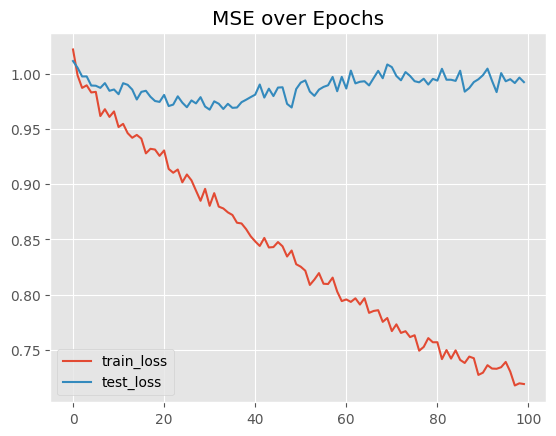

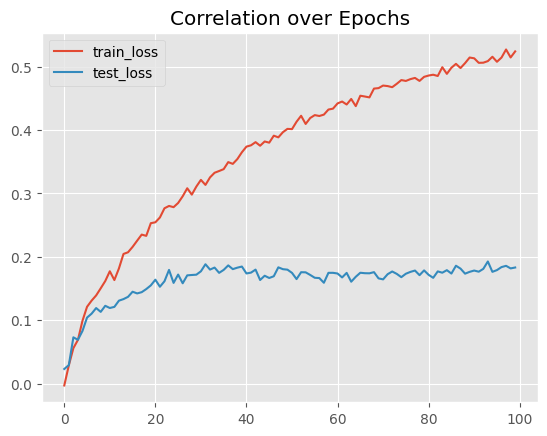

In [ ]:
model_causal.fit(z.train, test=z.test, epochs=100)

In [ ]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [ ]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = TransformerEncoderModelSparse(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_sparse = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


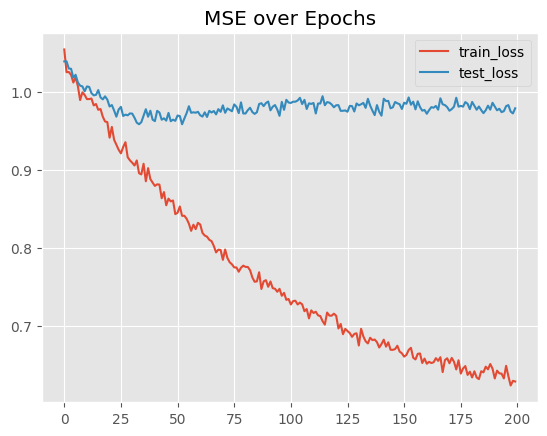

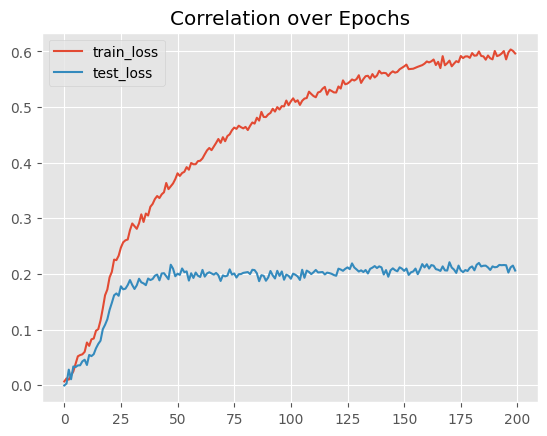

In [ ]:
model_sparse.fit(z.train, test=z.test, epochs=200)

In [ ]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = DualAttentionTransformerSparse(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=None).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_causal2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [ ]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = DualAttentionTransformerSparse(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_sparse2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


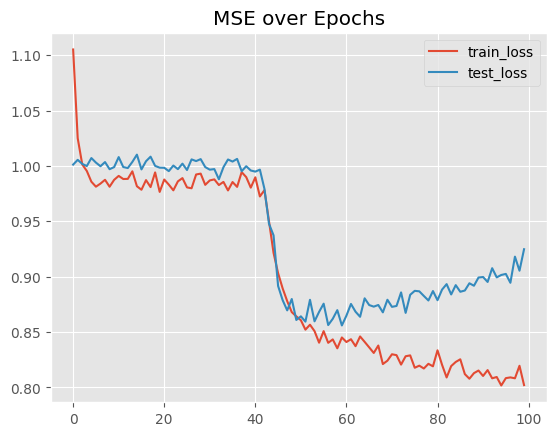

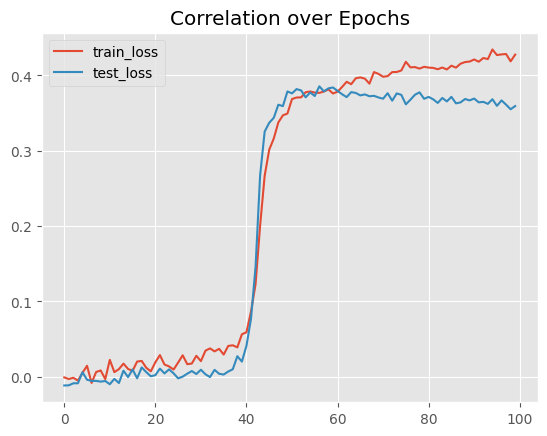

In [ ]:
model_causal2.fit(z.train, test=z.test, epochs=100)

100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


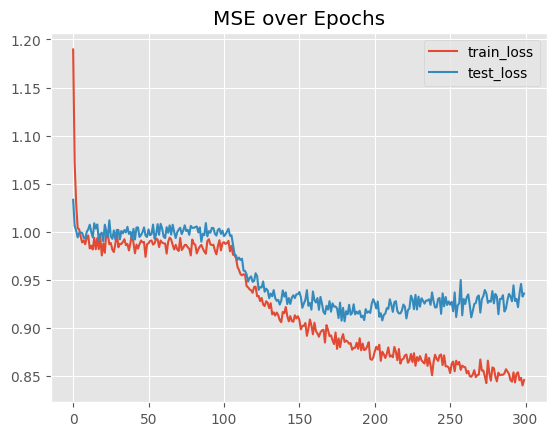

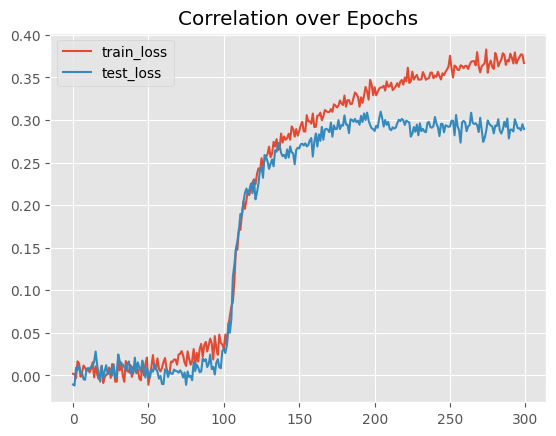

In [ ]:
model_sparse2.fit(z.train, test=z.test, epochs=200)

100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


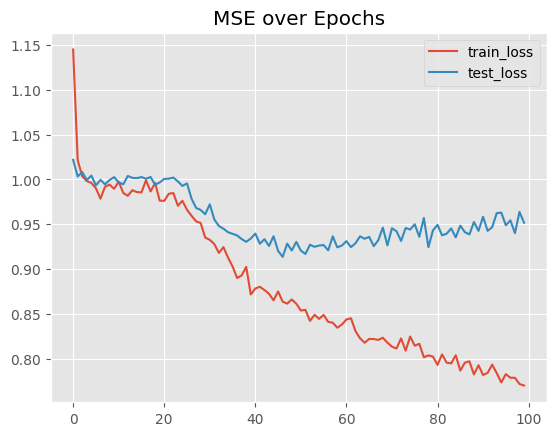

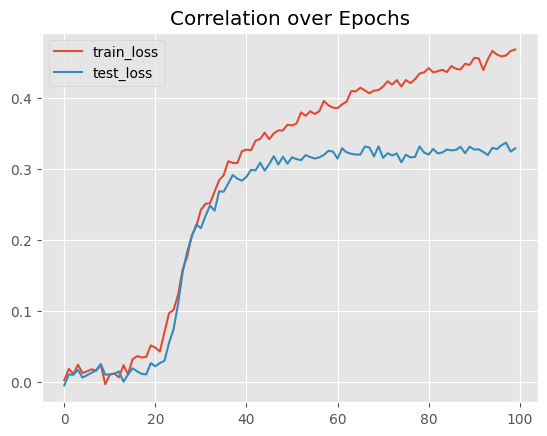

In [ ]:
m = MLPSpatioTransformerSparse(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, 
                               num_layers=2, mlp_layers=2, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_sparse3 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_sparse3.fit(z.train, test=z.test, epochs=100)

100%|██████████| 200/200 [05:59<00:00,  1.80s/it]


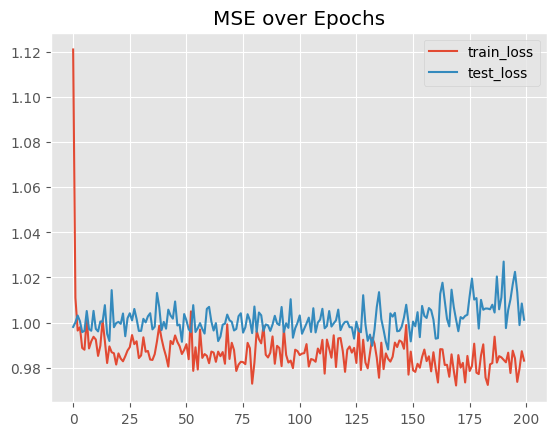

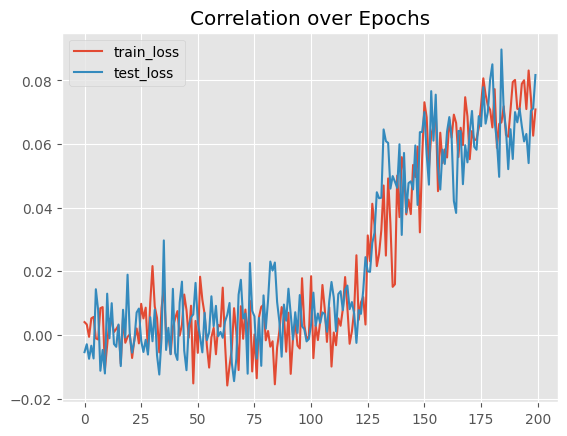

In [ ]:
m = AlternatingDualAttentionTransformerSparse(Config.n_ts, Config.n_f, 10, mask=mask, d_model=128, dim_feedforward=512, 
                                              dropout=0.5, num_layers=2, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_sparse4 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_sparse4.fit(z.train, test=z.test, epochs=200)

In [ ]:
comp = benchmark_comparison.Comparator(models=[model_causal, model_sparse, model_causal2, model_sparse2, model_sparse3, model_sparse4], 
                                        model_names=['causal', 'sparse', 'causal2', 'sparse2', 'sparse3', 'sparse4'])

In [ ]:
comp.correl(z, mode='train')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,cs_shift,causal,sparse,causal2,sparse2,sparse3
optimal,0.296,nan,nan,nan,nan,nan,nan,nan
cs_shift,0.296,1.000,nan,nan,nan,nan,nan,nan
causal,0.662,0.254,0.254,nan,nan,nan,nan,nan
sparse,0.783,0.266,0.266,0.606,nan,nan,nan,nan
causal2,0.449,0.615,0.615,0.441,0.465,nan,nan,nan
sparse2,0.422,0.460,0.460,0.429,0.443,0.681,nan,nan
sparse3,0.567,0.586,0.586,0.491,0.536,0.755,0.648,nan
sparse4,0.091,0.073,0.073,0.118,0.108,0.206,0.208,0.201


In [ ]:
comp.correl(z, mode='test')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,cs_shift,causal,sparse,causal2,sparse2,sparse3
optimal,0.309,nan,nan,nan,nan,nan,nan,nan
cs_shift,0.309,1.000,nan,nan,nan,nan,nan,nan
causal,0.187,0.190,0.190,nan,nan,nan,nan,nan
sparse,0.209,0.200,0.200,0.463,nan,nan,nan,nan
causal2,0.365,0.617,0.617,0.425,0.451,nan,nan,nan
sparse2,0.301,0.461,0.461,0.395,0.416,0.663,nan,nan
sparse3,0.324,0.594,0.594,0.384,0.418,0.745,0.622,nan
sparse4,0.098,0.086,0.086,0.103,0.139,0.207,0.222,0.230


# Training the model on multiple targets at once

In [150]:
# Let's try to update the code so using a (B, T, N, F), we train it on a (B, T, N) target instead of just (B, N) (corresponding to only the last step).
# This should hopefully make the training of transformer models much faster.

## Basic example

In [141]:
z.get_dataloader(n_rolling=10, roll_y='true')

In [142]:
# We modify the basic transformer model to the following

class TransformerEncoderModelMultiT(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts

        # Input projection
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            activation='gelu',  # usually better than relu
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # NEW: Direct prediction head applied to EVERY time step
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)   # output N values per time step
        )

    def forward(self, x, mask=None):
        # x: (B, T, N, F) where T == n_rolling
        B, T, N, F = x.shape
        assert T <= self.n_rolling, f"Input sequence length {T} > max {self.n_rolling}"

        # Flatten features
        x = x.reshape(B, T, N * F)                  # (B, T, N*F)
        x = self.input_proj(x)                      # (B, T, d_model)
        x = x + self.pos_embedding[:, :T, :]        # add pos encoding

        # Causal mask so each position only attends to past + itself
        causal_mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  # (B, T, d_model)

        # Predict at EVERY time step → (B, T, N)
        out = self.decoder(encoded)                  # (B, T, N)

        return out


In [86]:
# The code we use to train it is:

m = TransformerEncoderModelMultiT(Config.n_ts, Config.n_f, 10).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)



100%|██████████| 80/80 [00:24<00:00,  3.23it/s]


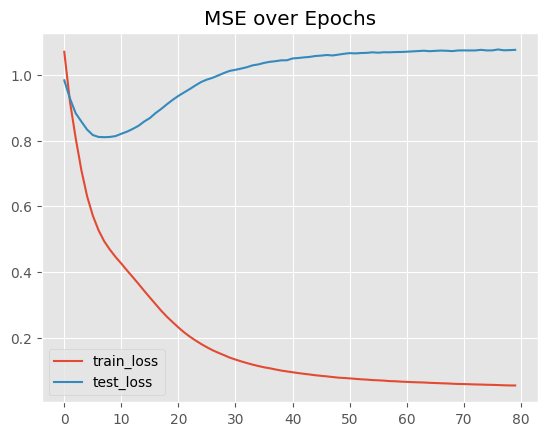

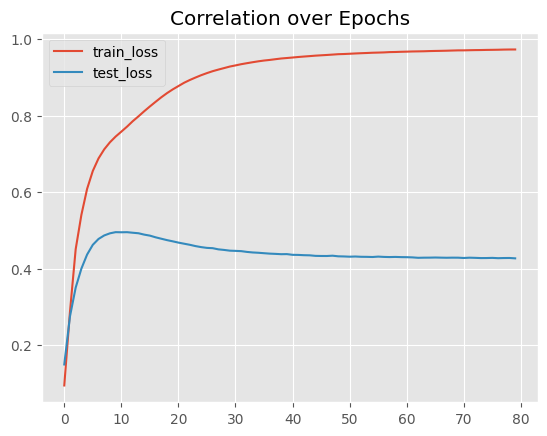

In [87]:
model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch.fit(z.train, test=z.test, epochs=80)

## CS transformer models in multiT

In [151]:
class DualAttentionTransformerMultiT(nn.Module):
    def __init__(
        self,
        n_ts,              # number of time series (N)
        n_f,               # number of input features per timestamp
        n_rolling,         # lookback window length (T)
        d_model=128,
        nhead_time=8,      # heads for temporal attention
        nhead_series=8,    # heads for cross-series attention
        num_layers_time=2,
        num_layers_series=2,
        dim_feedforward=512,
        dropout=0.1,       # ← lowered from 0.8 — 0.8 kills gradients!
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        # Input projection
        self.input_proj = nn.Linear(n_f, d_model)

        # Positional encodings
        self.pos_emb_time = nn.Parameter(torch.randn(1, n_rolling, d_model))
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, n_ts, d_model))  # (1,1,N,d_model)

        # Stage 1: Temporal Transformer (per series)
        temporal_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_time,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.temporal_transformer = nn.TransformerEncoder(
            temporal_layer, num_layers=num_layers_time
        )

        # Causal mask for temporal attention
        self.register_buffer(
            "causal_mask_time",
            torch.triu(torch.ones(n_rolling, n_rolling), diagonal=1).bool()
        )

        # Stage 2: Cross-Series Transformer — now applied per timestep!
        series_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_series,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.series_transformer = nn.TransformerEncoder(
            series_layer, num_layers=num_layers_series
        )

        self.output_head = nn.Sequential(
        nn.LayerNorm(d_model),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(d_model, 1)          # ← outputs (B,T,N,1)
    )
        
    def forward(self, x):
        """
        x : (B, T, N, F)
        Returns: (B, T, N) — prediction for every timestep and every series
        """
        B, T, N, F = x.shape

        # 1. Project input
        x = self.input_proj(x)                                      # (B, T, N, d_model)

        # 2. Add temporal positional encoding
        x = x + self.pos_emb_time[:, :T, :].unsqueeze(2)            # (B, T, 1, d_model)

        # 3. Temporal attention (independent per series)
        # Reshape: (B, T, N, d_model) → (B*N, T, d_model)
        x_temp = x.permute(0, 2, 1, 3).reshape(B * N, T, self.d_model)
        x_temp = self.temporal_transformer(x_temp, mask=self.causal_mask_time)
        x = x_temp.reshape(B, N, T, self.d_model).permute(0, 2, 1, 3)  # (B, T, N, d_model)

        # 4. Add series positional encoding
        x = x + self.pos_emb_series                                 # (B, T, N, d_model)

        # 5. Cross-Series attention — now per timestep!
        # Reshape: (B, T, N, d_model) → (B*T, N, d_model)
        x_series = x.reshape(B * T, N, self.d_model)
        x_series = self.series_transformer(x_series)                # (B*T, N, d_model)
        x = x_series.reshape(B, T, N, self.d_model)                 # (B, T, N, d_model)

        # 6. Predict at EVERY timestep
        out = self.output_head(x)          # (B, T, N, 1)
        out = out.squeeze(-1)              # ← NOW (B, T, N) — correct!

        return out

In [152]:
class AlternatingDualAttentionTransformerMultiT(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        d_model=128,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts

        self.input_proj = nn.Linear(n_f, d_model)

        # Positional embeddings
        self.pos_emb_time   = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))

        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList()
        for _ in range(num_layers):
            temp = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model, nhead, dim_feedforward, dropout,
                    activation="gelu", batch_first=True
                ),
                num_layers=1
            )
            series = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model, nhead, dim_feedforward, dropout,
                    activation="gelu", batch_first=True
                ),
                num_layers=1
            )
            self.blocks.append(nn.ModuleDict({
                'temporal': temp,
                'series': series,
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
            }))

        self.register_buffer(
            "causal_mask",
            torch.triu(torch.ones(n_rolling, n_rolling), diagonal=1).bool()
        )

        # FIXED: Predict 1 value per series per timestep
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)          # ← NOW CORRECT
        )

    def forward(self, x):
        B, T, N, _ = x.shape

        x = self.input_proj(x)                                      # (B, T, N, d_model)
        x = x + self.pos_emb_time + self.pos_emb_series

        for block in self.blocks:
            # Temporal attention
            res = x
            x = x.permute(0, 2, 1, 3).reshape(B * N, T, self.d_model)
            x = block['temporal'](x, mask=self.causal_mask)
            x = x.reshape(B, N, T, self.d_model).permute(0, 2, 1, 3)
            x = block['norm1'](res + self.dropout(x))

            # Cross-series attention
            res = x
            x = x.reshape(B * T, N, self.d_model)
            x = block['series'](x)
            x = x.reshape(B, T, N, self.d_model)
            x = block['norm2'](res + self.dropout(x))

        # Predict at every timestep → (B, T, N, 1) → squeeze → (B, T, N)
        out = self.output_head(x)          # (B, T, N, 1)
        out = out.squeeze(-1)              # ← NOW (B, T, N) — perfect!

        return out

## Comparing both setups

In [153]:
# Here lets compare running the dual transformer using both setups

In [154]:
@dataclass
class Config:
    T: int = 3000
    n_ts: int = 5
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.25
    split_shift: float = 0.25
    split_seasonal: float = 0.
    split_cs: float = 0.25
    split_cs_shift: float = 0.25
    low_corr: float = 0.1
    high_corr: float = 0.2

# @dataclass
# class Config:
#     T: int = 3000
#     n_ts: int = 20
#     n_f: int = 10
#     pct_zero_corr: float = 0.5
#     split_conditional: float = 1.0
#     split_shift: float = 0.
#     split_seasonal: float = 0.
#     split_cs: float = 0.
#     split_cs_shift: float = 0.
#     low_corr: float = 0.1
#     high_corr: float = 0.2


In [155]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [156]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 5.62 ms, sys: 2.93 ms, total: 8.54 ms
Wall time: 8.18 ms


In [157]:
z.get_dataloader(n_rolling=10)

100%|██████████| 40/40 [00:24<00:00,  1.65it/s]


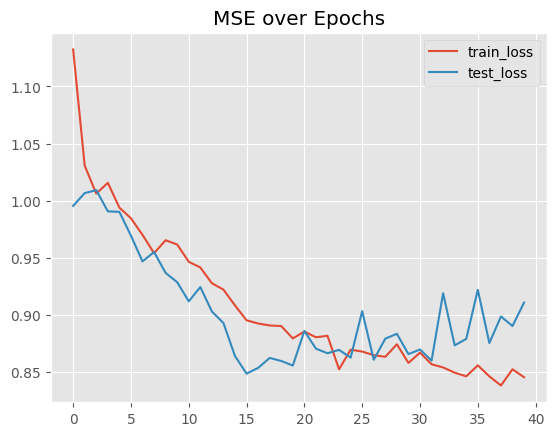

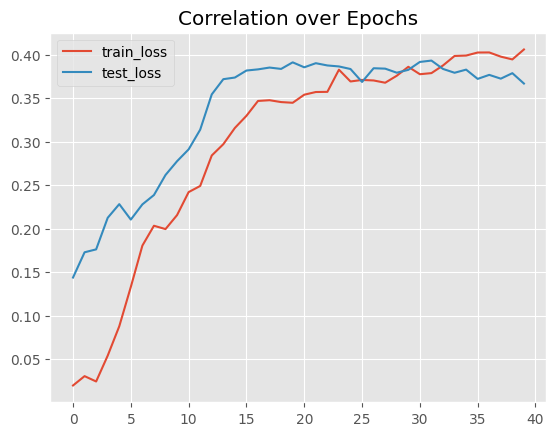

In [158]:
m = DualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers_series=2, num_layers_time=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch2.fit(z.train, test=z.test, epochs=40)

100%|██████████| 60/60 [00:59<00:00,  1.00it/s]


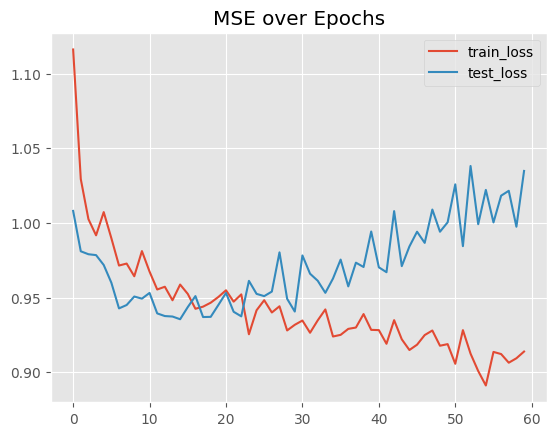

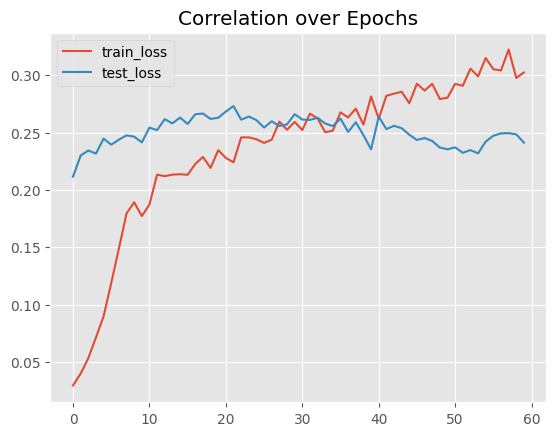

In [159]:
m = AlternatingDualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch4 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch4.fit(z.train, test=z.test, epochs=60)

In [160]:
z.get_dataloader(n_rolling=10, roll_y=True)

In [161]:
# The code we use to train it is:

m = DualAttentionTransformerMultiT(
    n_ts=Config.n_ts,
    n_f=Config.n_f,
    n_rolling=10,
    d_model=128,
    nhead_time=8,
    nhead_series=8,
    num_layers_time=2,
    num_layers_series=2,
    dropout=0.3
).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


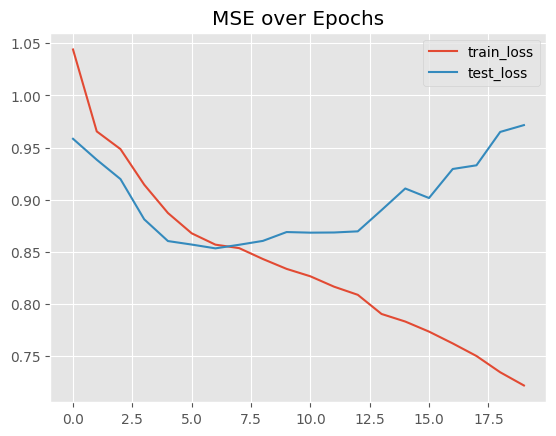

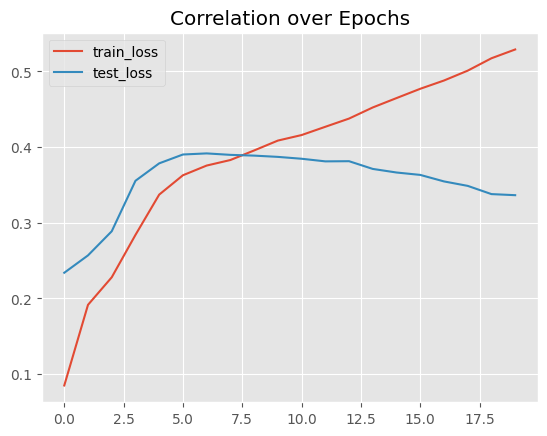

In [162]:
model_torch2_multi = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch2_multi.fit(z.train, test=z.test, epochs=20)

100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


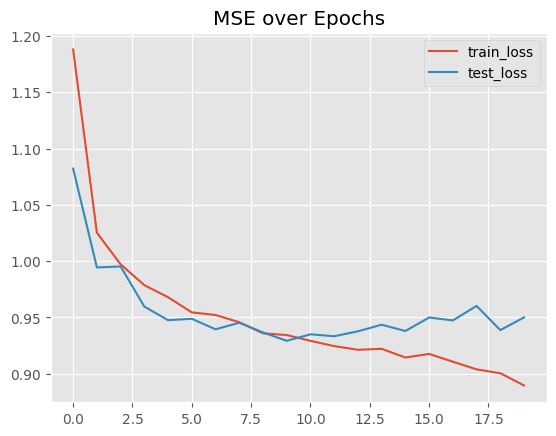

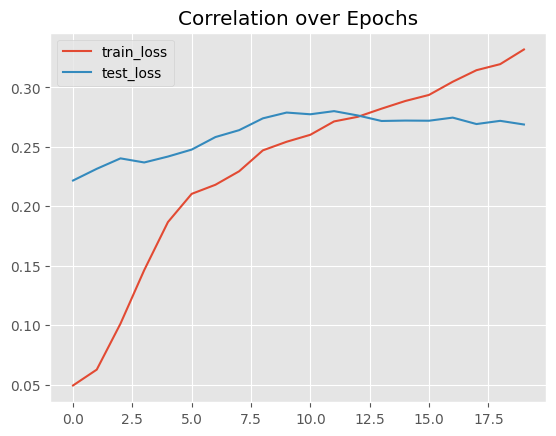

In [163]:
# The code we use to train it is:

m = AlternatingDualAttentionTransformerMultiT(
    n_ts=Config.n_ts,
    n_f=Config.n_f,
    n_rolling=10,
    d_model=128,
    nhead=8,
    num_layers=2,
    dropout=0.3
).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_torch4_multi = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch4_multi.fit(z.train, test=z.test, epochs=20)

In [164]:
comp = benchmark_comparison.Comparator(models=[model_torch2, model_torch4, model_torch2_multi, model_torch4_multi],
                                        model_names=['transformer2', 'transformer4', 'transformer_multi2', 'transformer_multi4'])

In [165]:
comp.correl(z, mode='train')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,linear,conditional,shift,cs,cs_shift,transformer2,transformer4,transformer_multi2
optimal,0.334,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.125,0.360,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.099,0.342,0.013,nan,nan,nan,nan,nan,nan,nan
shift,0.145,0.422,0.011,0.012,nan,nan,nan,nan,nan,nan
cs,0.195,0.580,0.041,0.014,0.029,nan,nan,nan,nan,nan
cs_shift,0.198,0.583,0.027,0.031,0.042,0.031,nan,nan,nan,nan
transformer2,0.495,0.691,0.318,0.125,0.330,0.416,0.384,nan,nan,nan
transformer4,0.377,0.341,0.392,0.120,0.104,0.179,0.084,0.631,nan,nan
transformer_multi2,0.653,0.618,0.243,0.148,0.255,0.377,0.371,0.813,0.554,nan
transformer_multi4,0.386,0.375,0.381,0.186,0.110,0.203,0.088,0.633,0.841,0.577


In [166]:
comp.correl(z, mode='test')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,linear,conditional,shift,cs,cs_shift,transformer2,transformer4,transformer_multi2
optimal,0.341,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.133,0.370,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.105,0.342,0.013,nan,nan,nan,nan,nan,nan,nan
shift,0.172,0.415,0.062,0.012,nan,nan,nan,nan,nan,nan
cs,0.198,0.577,0.016,0.019,0.015,nan,nan,nan,nan,nan
cs_shift,0.184,0.594,0.047,0.031,0.017,0.054,nan,nan,nan,nan
transformer2,0.369,0.691,0.321,0.128,0.335,0.416,0.383,nan,nan,nan
transformer4,0.246,0.300,0.395,0.105,0.098,0.144,0.060,0.594,nan,nan
transformer_multi2,0.345,0.628,0.242,0.146,0.264,0.382,0.386,0.803,0.498,nan
transformer_multi4,0.263,0.347,0.382,0.187,0.122,0.175,0.061,0.595,0.820,0.516


# Running many models on many datasets

In [ ]:
# Global data
num_time_steps = 3000
num_time_series = 5
num_features = 10

In [ ]:
num_epochs = 10
choice_optimizer = "AdamW" #Choose between "SGD", "Adam", "AdamW"
learning_rate = 0.001
weight_decay = 0.01 #For AdamW only

## Defining the data

In [ ]:
@dataclass
class Config:
    T: int = num_time_steps
    n_ts: int = num_time_series
    n_f: int = num_features
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.0
    split_shift: float = 0.0
    split_seasonal: float = 0.0
    split_cs: float = 0.0
    split_cs_shift: float = 0.0
    #split_cs_shift: float = 1.0
    low_corr: float = 0.1
    high_corr: float = 0.2

In [ ]:
dic_data = {}

z1 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z1.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = 1.0,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z1.get_dataloader(n_rolling=10)

z2 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z2.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = 1.0,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z2.get_dataloader(n_rolling=10)

z3 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z3.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs= 1.0,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z3.get_dataloader(n_rolling=10)

z4 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z4.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=1.0,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z4.get_dataloader(n_rolling=10)


dic_data["d_cond"] = z1
dic_data["d_shift"] = z2
dic_data["d_cs"] = z3
dic_data["d_cs_shift"] = z4

## Defining the models

In [ ]:
# Let's also define a dic of models, varying here dropout in the basic transformer.

In [ ]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [ ]:
#dropout_values = [0, 0.25, 0.5, 0.8, 0.85, 0.9]
dropout_values = [0.25, 0.8,]

In [ ]:
dic_models = {}

for i in range(len(dropout_values)):
    m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, dropout=dropout_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "m_dropout_" + str(dropout_values[i])
    dic_models[model_name] = m  


In [ ]:
dic_models.keys()

dict_keys(['m_dropout_0.25', 'm_dropout_0.8'])

In [ ]:
dic_data.keys()

dict_keys(['d_cond', 'd_shift', 'd_cs', 'd_cs_shift'])

## Running all the models on all the data

In [ ]:
# OK now let's run the code on all the models.

In [ ]:
#Let's now run the above on all the indexes and see what we get

correls_IS = np.zeros((len(dic_models.keys()), len(dic_data.keys())))
correls_OOS = np.zeros((len(dic_models.keys()), len(dic_data.keys())))

keys_model = list(dic_models.keys())
keys_data = list(dic_data.keys())

for index1 in range(len(keys_model)):
    for index2 in range(len(keys_data)):

        model_name = keys_model[index1]
        data_name = keys_data[index2]
        
        z = dic_data[data_name]
        m = dic_models[model_name]
        
        if choice_optimizer=="Adam":
            optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
        elif choice_optimizer=="AdamW":
            optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.SGD(m.parameters(), lr=learning_rate)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=num_epochs, plot=False)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        correls_IS[index1][index2] = out_train
        correls_OOS[index1][index2] = out_test

        print(model_name, data_name, " done")

pd_correls_IS = pd.DataFrame(correls_IS, index=keys_model, columns=keys_data)
pd_correls_OOS = pd.DataFrame(correls_OOS, index=keys_model, columns=keys_data)

  0%|          | 0/10 [00:00<?, ?it/s]100%|██████████| 10/10 [00:02<00:00,  4.70it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_cond  done


100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_shift  done


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_cs  done


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_cs_shift  done


100%|██████████| 10/10 [00:01<00:00,  5.28it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_cond  done


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_shift  done


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_cs  done


100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_cs_shift  done


In [ ]:
print("Correlation IS between model prediction and optimal y for the different models and the different datasets.")
pd_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between model prediction and optimal y for the different models and the different datasets.


,d_cond,d_shift,d_cs,d_cs_shift
m_dropout_0.25,0.1108,0.6147,0.5857,0.5395
m_dropout_0.8,0.0091,0.0130,0.0869,0.0282


In [ ]:
print("Correlation OOS between model prediction and optimal y for the different models and the different datasets.")
pd_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation OOS between model prediction and optimal y for the different models and the different datasets.


,d_cond,d_shift,d_cs,d_cs_shift
m_dropout_0.25,0.0151,0.5909,0.5862,0.5125
m_dropout_0.8,0.0229,0.0209,0.0848,0.0142
